In [2]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
from cmocean import cm
import xgcm
import cartopy.feature as cfeature
from matplotlib import pyplot as plt
%matplotlib inline

#from mitequinox.utils import *
#from mitequinox.utils import *
from mitequinox.dynamic import *
from mitequinox.plot import *

In [3]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(10)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [4]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [5]:
client

Client Scheduler: tcp://10.148.1.25:58736 Dashboard: http://10.148.1.25:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


_____

# 1. compute KE_tmean

In [6]:
data_dir = '/home1/scratch/xyu/mit_zarr/UV/LLC1080_t/'

SSU = xr.concat([xr.open_zarr(data_dir+'SSU_t%04d.zarr'%time) for time in range(3)], dim='time', compat='equals')
SSV = xr.concat([xr.open_zarr(data_dir+'SSV_t%04d.zarr'%time) for time in range(3)], dim='time', compat='equals')
mgrid = xr.open_dataset('/home1/datawork/xyu/grid/mit_grid_t_1080.nc', decode_coords=True)
ds = xr.merge([SSU, SSV, mgrid])
print(ds)

<xarray.Dataset>
Dimensions:  (face: 13, i: 1080, i_g: 1080, j: 1080, j_g: 1080, time: 3)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 ...
  * j        (j) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
    dtime    (time) datetime64[ns] dask.array<shape=(3,), chunksize=(1,)>
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06
  * i        (i) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
  * j_g      (j_g) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 ...
    XC       (face, i, j) float32 ...
    YC       (face, i, j) float32 ...
    XG       (face, i_g, j_g) float32 ...
    YG       (face, i_g, j_g) float32 ...
    CS       (face, i, j) float32 ...
    SN       (face, i, j) float32 ...
    rA       (face, i, j) float32 ...
    dxG      (face, i, j_g) float32 ...
    dyG      (face, j, i_g) float32 ...
    Depth    (face, i, j) float32 .

In [34]:
#import xgcm
grid = xgcm.Grid(ds, periodic=['X', 'Y'])
grid

<xgcm.Grid>
X Axis (periodic):
  * center   i (1080) --> left
  * left     i_g (1080) --> center
Y Axis (periodic):
  * center   j (1080) --> left
  * left     j_g (1080) --> center

In [35]:
KE = grid.interp(ds['SSU'] * ds['SSU'],'X') + grid.interp(ds['SSV'] * ds['SSV'],'Y')
KE = KE.chunk({'i': 1080, 'j':1080})
KE_tmean = KE.mean(dim='time')
KE_tmean = np.real(KE_tmean).rename('KE_tmean')
KE_tmean = xr.merge([KE_tmean, mgrid])
file_E = data_dir+'KE_tmean_1080.zarr'
%time KE_tmean.to_zarr(file_E, mode='w')  

CPU times: user 3.78 s, sys: 1.4 s, total: 5.18 s
Wall time: 19.6 s


_______
# 2. Load dataset

In [7]:
data_dir = '/home1/scratch/xyu/mit_zarr/UV/LLC1080_t/'

mKE = xr.open_zarr(data_dir+'KE_tmean_1080.zarr') 
KE_tmean = mKE.KE_tmean
KE_tmean

<xarray.DataArray 'KE_tmean' (face: 13, j: 1080, i: 1080)>
dask.array<shape=(13, 1080, 1080), dtype=float32, chunksize=(13, 1080, 1080)>
Coordinates:
    CS       (face, i, j) float32 dask.array<shape=(13, 1080, 1080), chunksize=(4, 270, 270)>
    Depth    (face, i, j) float32 dask.array<shape=(13, 1080, 1080), chunksize=(4, 270, 270)>
    SN       (face, i, j) float32 dask.array<shape=(13, 1080, 1080), chunksize=(4, 270, 270)>
    XC       (face, i, j) float32 dask.array<shape=(13, 1080, 1080), chunksize=(4, 270, 270)>
    YC       (face, i, j) float32 dask.array<shape=(13, 1080, 1080), chunksize=(4, 270, 270)>
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
  * j        (j) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
    rA       (face, i, j) float32 dask.array<shape=(13, 1080, 1080), chunksize=(4, 270, 270)>

# Plot

In [6]:
_region_params = {'atlantic': {'faces':[0,1,2,6,10,11,12],'extent':[-110,25,-70,70], 'projection': ccrs.Mollweide()}, 
                  'south-atlantic':{'faces':[1,11,0,12],'extent':[-50,20,-60,5],
                                    'projection': ccrs.LambertAzimuthalEqualArea(central_longitude=-15.,
                                                                                 central_latitude=-30)}}

def plot_pretty(v, colorbar=False, title=None, vmin=None, vmax=None, savefig=None, 
                offline=False, coast_resolution='110m', figsize=(25,25), cmap=None,
                ignore_face=[], projection=None, extent=None, region=None):
    #
    if vmin is None:
        vmin = v.min()
    if vmax is None:
        vmax = v.max()
    #
    MPL_LOCK = threading.Lock()
    with MPL_LOCK:
        if offline:
            plt.switch_backend('agg')
        colmap = _get_cmap(v, cmap)
        #
        if 'face' not in v.dims:
            v = v.expand_dims('face')
        if region is not None:
            _extent = _region_params[region]['extent']
            gen = (face for face in _region_params[region]['faces'] 
                   if face not in ignore_face)
            _projection = _region_params[region]['projection']
        else:
            gen = (face for face in v.face.values if face not in ignore_face)
            _projection = ccrs.Robinson()
            _extent = None
        print(gen)
        if extent is not None:
            _extent = extent
        if projection is not None:
            _projection = projection
        #
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection=_projection)
        if _extent is not None:
            ax.set_extent(_extent)
        for face in gen:
            vplt = v.sel(face=face)
            #print(face)
            if face in [6,7,8,9]:
                # this deals with dateline crossing areas
                im = vplt.where( (vplt.XC>0) & (vplt.XC<179.)).plot.pcolormesh(ax=ax,
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', cmap=colmap, add_colorbar=False)
                im = vplt.where(vplt.XC<0).plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', cmap=colmap, add_colorbar=False)
            else:
                im = vplt.plot.pcolormesh(ax=ax,                   
                                transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax,
                                x='XC', y='YC', cmap=colmap, add_colorbar=False)
        if colorbar:
            fig.colorbar(im)
        # grid lines:
        gl = ax.gridlines()

        # coastlines and land:
        ax.add_feature(cfeature.LAND)
        #
        if title is not None:
            ax.set_title(title,fontdict={'fontsize':20, 'fontweight':'bold'})
        #
        if savefig is not None:
            fig.savefig(savefig, dpi=150)
            plt.close(fig)
        #
        #if not offline:
        #    plt.show()
        return fig, ax
    
_default_cmaps = {'SSU': cm.balance, 'SSV': cm.balance,
           'SSU_geo': cm.balance, 'SSV_geo': cm.balance,
           'Eta': plt.get_cmap('RdGy_r'), 
           'SST': cm.thermal, 'SSS': cm.haline}

def _get_cmap(v, cmap):
    if cmap is None and v.name in _default_cmaps:
        return _default_cmaps[v.name]
    elif cmap is not None:
        return cmap
    else:
        return plt.get_cmap('magma')

(<Figure size 1080x1080 with 2 Axes>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x2aab048a3438>)

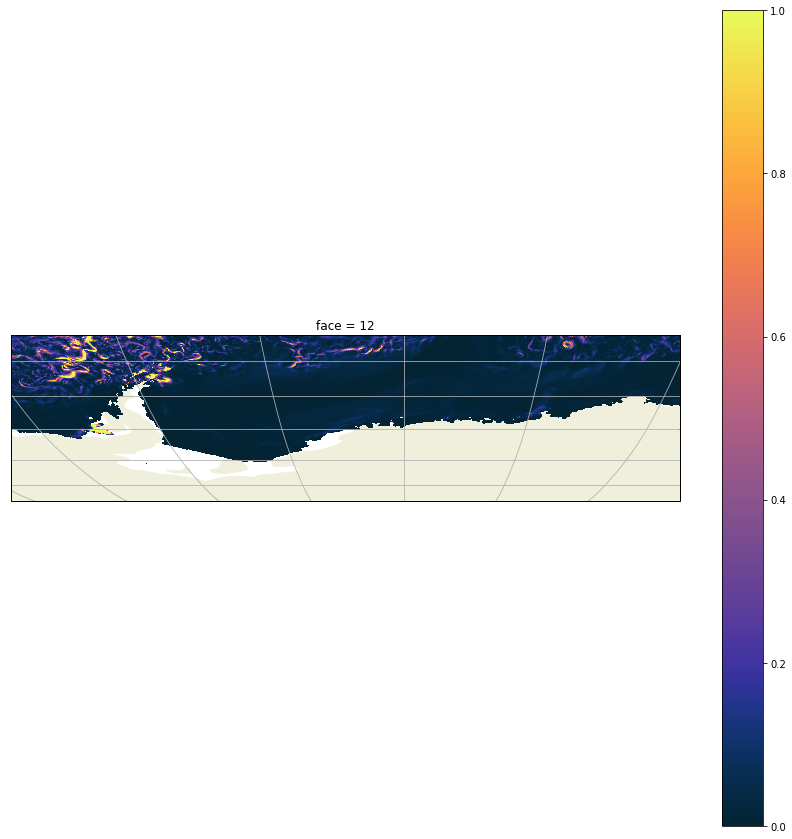

In [8]:
import cartopy.feature as cfeature
import pandas as pd
#from mitequinox.plot import *
plot_pretty(KE_tmean, vmin=0, vmax=1, cmap=cm.thermal, colorbar=True)

In [8]:
def quick_llc_plot(data, axis_off=False, **kwargs):
    face_to_axis = {0: (2, 0), 1: (1, 0), 2: (0, 0),
                    3: (2, 1), 4: (1, 1), 5: (0, 1),
                    7: (0, 2), 8: (1, 2), 9: (2, 2),
                    10: (0, 3), 11: (1, 3), 12: (2, 3)}
    transpose = [7, 8, 9, 10, 11, 12]
    gridspec_kw = dict(left=0, bottom=0, right=4, top=4, wspace=0, hspace=0)
    fig, axes = plt.subplots(nrows=3, ncols=4, gridspec_kw=gridspec_kw)
    for face, (j, i) in face_to_axis.items():
        data_ax = data.isel(face=face)
        ax = axes[j,i]
        yincrease = True
        if face in transpose:
            data_ax = data_ax.transpose()
            yincrease = False
        data_ax.plot(ax=ax, yincrease=yincrease, **kwargs)
        if axis_off:
            ax.axis('off')
        ax.set_title('')

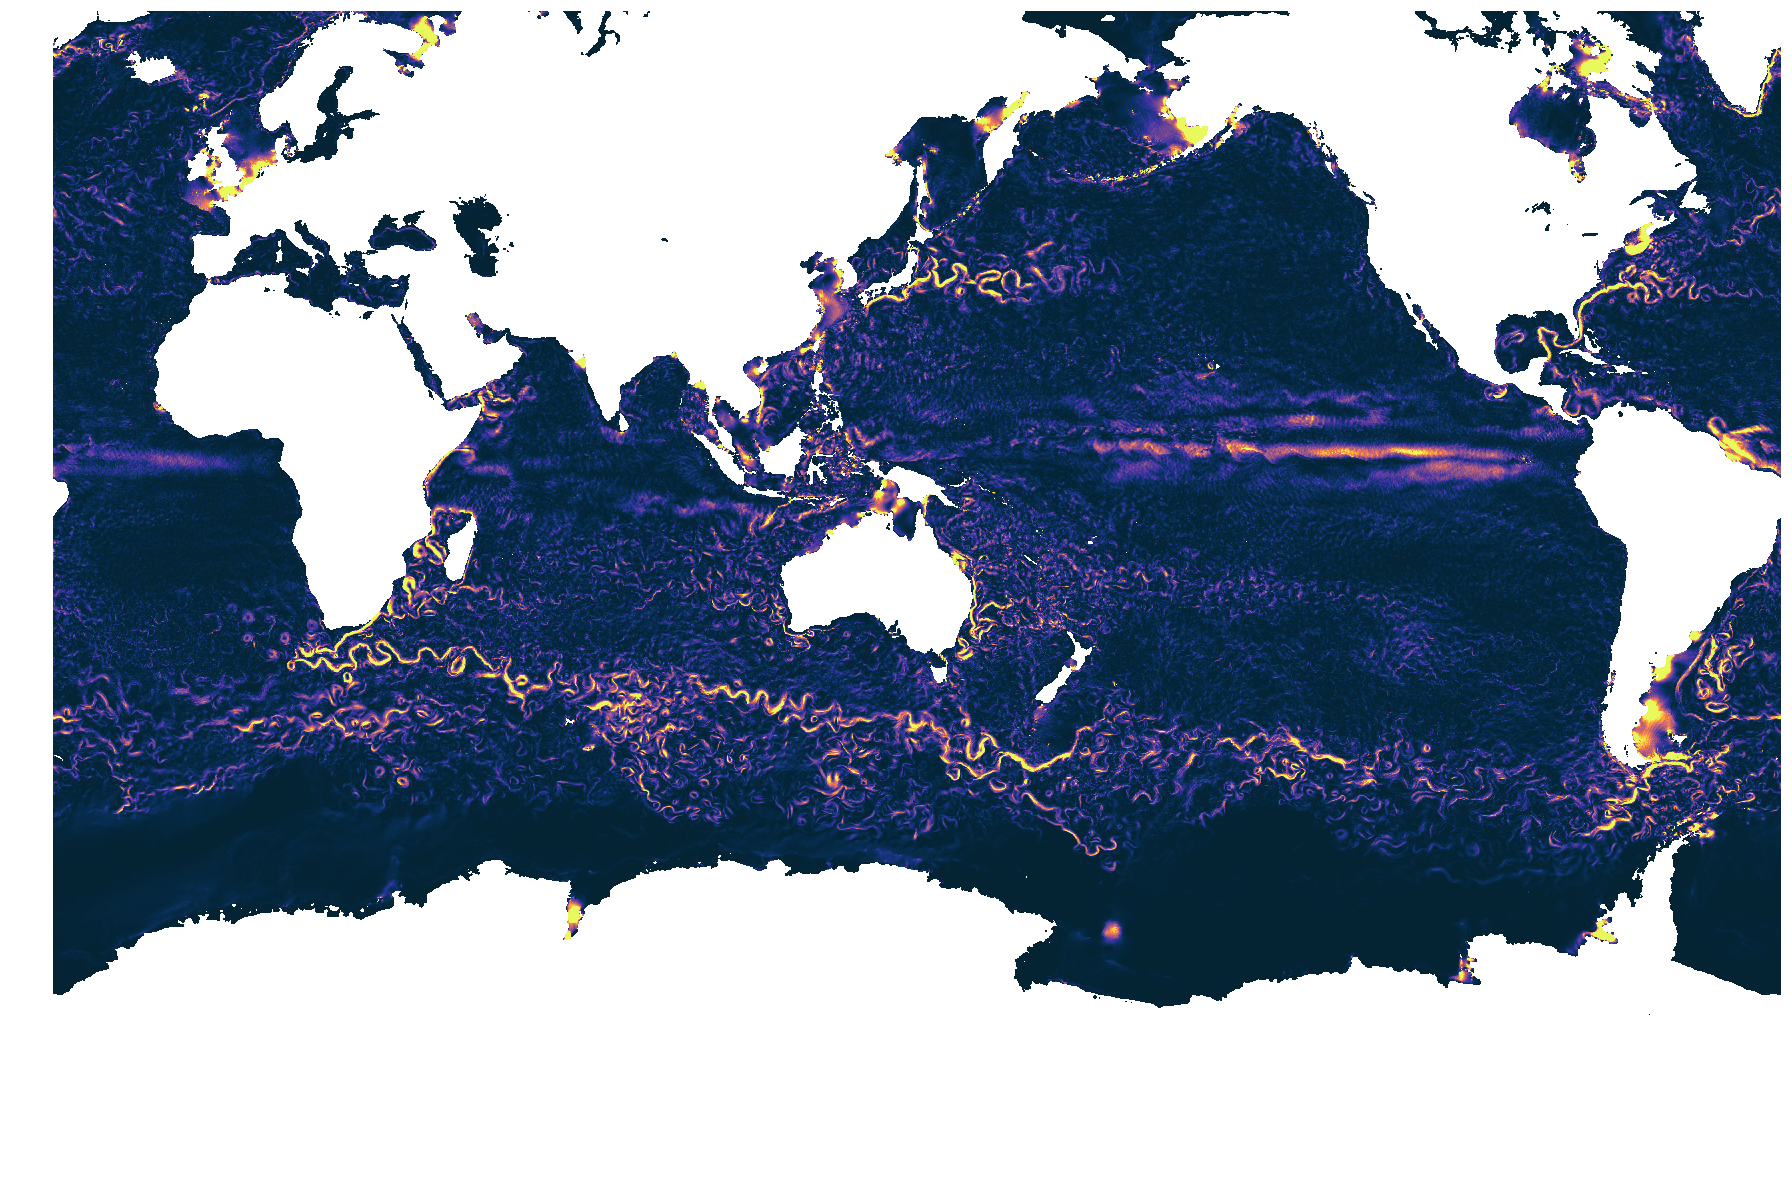

In [9]:
quick_llc_plot(KE_tmean, vmin=0, vmax=1, add_colorbar=False, axis_off=True, cmap = cm.thermal)

In [11]:
cluster.scheduler.close()

<Future finished result=None>